# **1000-719bMSB Modeling of Complex Biological Systems**
# **Deep Neural Network: Unsupervised Learning**

# Variational Autoencoder on MNIST

VAEs are directed probabilistic graphical models (DPGM) whose posterior is approximated by a neural network, forming an autoencoder-like architecture. Unlike discriminative modeling that aims to learn a predictor given observation, generative modeling tries to learn how the data is generated, and to reflect the underlying causal relations. [...] Variational autoencoder models make strong assumptions concerning the distribution of latent variables. They use a variational approach for latent representation learning, which results in an additional loss component and a specific estimator for the training algorithm called the Stochastic Gradient Variational Bayes (SGVB) estimator. [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

We build a VAE and train it on the MNIST dataset.  

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
tf.compat.v1.disable_eager_execution()
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np


img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

TensorFlow 1.x selected.
1.15.2


Using TensorFlow backend.


In [2]:
#Define encoder network
#Note that we are using keras functional API
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
#x = layers.Dense(2, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
#Sampling from the distributions to obtain latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img, z)

In [4]:
#Define decoder network
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [5]:
def vae_loss(input_img, z_decoded):
    input_img = K.flatten(input_img)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(input_img, z_decoded) 
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [6]:
vae = Model(input_img, z_decoded)
vae.compile(optimizer='adam', loss=vae_loss)

In [7]:
vae.summary()
decoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

In [8]:
#load the data and split into train + test sets
(x_train, _), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [9]:
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

We are ready to train VAE on this dataset 

In [10]:
vae.fit(x=x_train,y=x_train, shuffle=True, epochs=10, batch_size=batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
60000/60000 [==============================] - 29s 475us/step - loss: 0.2188
Epoch 2/10
60000/60000 [==============================] - 22s 367us/step - loss: 0.1955
Epoch 3/10
60000/60000 [==============================] - 23s 384us/step - loss: 0.1900
Epoch 4/10
60000/60000 [==============================] - 22s 365us/step - loss: 0.1870
Epoch 5/10
60000/60000 [==============================] - 22s 368us/step - loss: 0.1849
Epoch 6/10
60000/60000 [==============================] - 22s 367us/step - loss: 0.1831
Epoch 7/10
60000/60000 [==============================] - 22s 367us/step - loss: 0.1819
Epoch 8/10
60000/60000 [==============================] - 22s 365us/step - loss: 0.1809
Epoch 9/10
60000/60000 [==============================] - 22s 368us/step - loss: 0.1800
Epoch 10/10
60000/60000 [==============================] - 22s 365us/step - loss: 0.1793


In [11]:
# to save the trained VAE on Google Drive and load them later. Not necessary
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
vae.save_weights('drive/My Drive/Colab Notebooks/vae_weights.h5')
vae.load_weights('drive/My Drive/Colab Notebooks/vae_weights.h5')

AttributeError: ignored

In [14]:
# x_test is data
# encoded: means we are mapping our data point (x_test) into latent space; give us a point in latent space
encoded = encoder.predict(x_test)

In [15]:
print(encoded)

[[ 0.9103096  -0.3804238 ]
 [-3.2954562  -0.69909704]
 [ 3.0439892  -1.4777249 ]
 ...
 [ 0.8369086  -0.11318865]
 [ 0.9286805   1.464087  ]
 [-0.45482257  0.8280175 ]]


[ 0.9103096 -0.3804238]


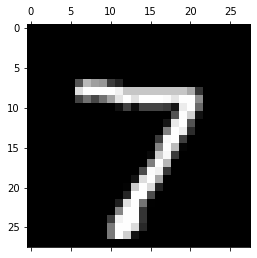

In [16]:
print(encoded[0])
plt.matshow(x_test[0][:,:,0], cmap='gray')

[-3.2954562  -0.69909704]


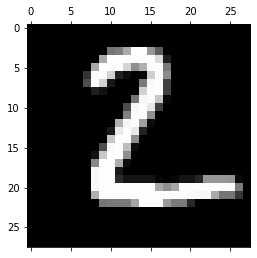

In [17]:
print(encoded[1])
plt.matshow(x_test[1][:,:,0], cmap='gray')

In [18]:

# decoded: reconstructing
decoded = decoder.predict(encoded)

#decoded_some_random = decoder.predict()

TypeError: ignored

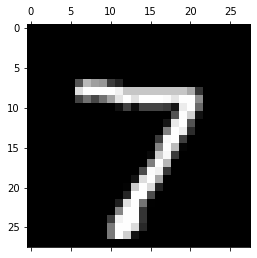

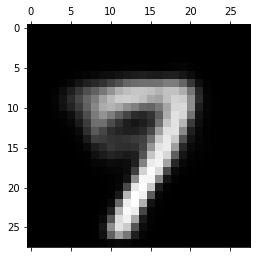

In [19]:
plt.matshow(x_test[0][:,:,0], cmap='gray')
plt.matshow(decoded[0][:,:,0], cmap='gray')

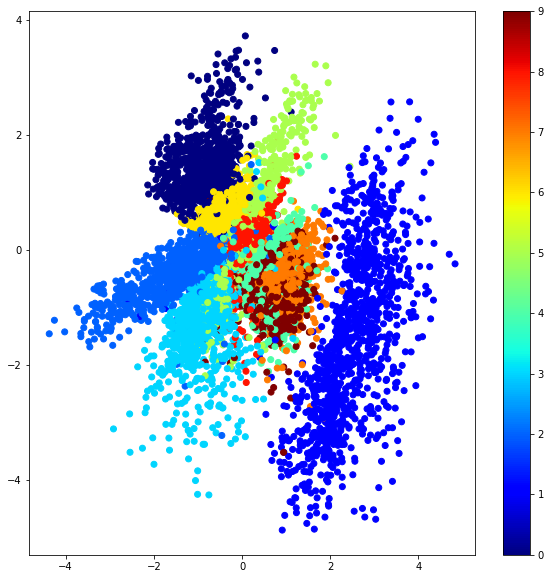

In [20]:
x_test_encoded = encoder.predict(x_test)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

**HOMEWORK 1** 

Interpolate between two latent vectors (i.e., moving in the latent space) and decode and visualize the interpolations. Provide a code (python notebook) to do this interpolation; and provide 3 interpolated images in-between.

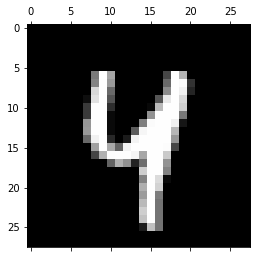

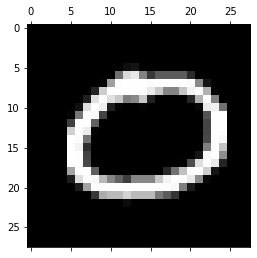

In [52]:
v1, v2 = encoded[42], encoded[69]
v1_img, v2_img = x_test[42], x_test[69]

plt.matshow(v1_img[:,:,0], cmap='gray')
plt.matshow(v2_img[:,:,0], cmap='gray')

In [61]:
interpolations = [(1.0 - ratio)*v1 + ratio*v2 for ratio in np.linspace(0, 1, num=5)]
steps = np.array(interpolations)
steps

decoded_steps = decoder.predict(steps)

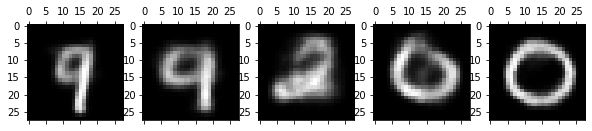

In [62]:
fig, axes = plt.subplots(1,5, figsize=(10,2))
for step, axis in zip(decoded_steps, axes):
  axis.matshow(step[:,:,0], cmap='gray')
plt.show()

# DeepDream

[Read the introduction to DeepDream](https://web.archive.org/web/20150703064823/http://googleresearch.blogspot.co.uk/2015/06/inceptionism-going-deeper-into-neural.html)

In [ ]:
from keras.applications import inception_v3
from keras import backend as K
#disable all training-specific options
K.set_learning_phase(0)

In [ ]:
model = inception_v3.InceptionV3(weights='imagenet',
include_top=False)

In [ ]:
model.summary()

In [ ]:
#coefficients for contribution of selected layers
layer_contributions = {
'mixed2': 0.2,
'mixed3': 3.,
'mixed4': 2.,
'mixed5': 1.5,
}

In [ ]:
#Creates a dictionary that maps layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [ ]:
layer_dict['mixed2']

In [ ]:
#define the loss
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    #here the loss is the L2 norm of activations of whole layer 
    #before: only chosen filter
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling   

In [ ]:
#define gradient-ascent process

#this was before a noise image, now image of choice
dream = model.input

#gradient of loss wrt input image
grads = K.gradients(loss, dream)[0]
#normalize gradient
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values
    
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x = x + step * grad_values
    return x

In [ ]:
#define some auxilliary function
import scipy
from keras.preprocessing import image
import imageio
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
    float(size[0]) / img.shape[1],
    float(size[1]) / img.shape[2],
    1)
    return scipy.ndimage.zoom(img, factors, order=1)
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imwrite(fname, pil_img)
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(400,400))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        #undoes the preprocessing done by inception_v3.preprocess_input
        x = x.reshape((x.shape[1], x.shape[2], 3))
        x /= 2.
        x += 0.5
        x *= 255.
        x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
base_image_path = 'drive/My Drive/Colab Notebooks/hill_wiki.jpg'
img = preprocess_image(base_image_path)

In [ ]:
step = 0.01
iterations = 20
max_loss = 10.

img = gradient_ascent(img,
        iterations=iterations,
        step=step,
        max_loss=max_loss)

plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(deprocess_image(img))

In [ ]:
import numpy as np
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.
base_image_path = 'drive/My Drive/Colab Notebooks/hill_wiki.jpg'
img = preprocess_image(base_image_path)

In [ ]:
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i))
        for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

In [ ]:
successive_shapes

In [ ]:
#to make the effect look cooler
for shape in successive_shapes:
    print('Processing image shape', shape)
    #upscale image and apply gradient descent
    img = resize_img(img, shape)
    img = gradient_ascent(img,
        iterations=iterations,
        step=step,
        max_loss=max_loss)
    
    #insert details lost by upscaling
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape) #will be pixelated
    same_size_original = resize_img(original_img, shape)                  #high-quality image by downscaling original
    lost_detail = same_size_original - upscaled_shrunk_original_img       #detail that was lost when scaling up

    img = img + lost_detail #reinsert the detail
    shrunk_original_img = resize_img(original_img, shape)

In [ ]:
plt.imshow(deprocess_image(img))